# Family cross-validation analysis

[description]

## Imports and configuration

In [7]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings

# Import custom functions
from diabnet.ensemble import Ensemble
from diabnet.analysis.report import DiabNetReport
from diabnet.analysis.analysis import barplot
from diabnet.apply_ensemble import Predictor
from diabnet.data import get_feature_names, DiabDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


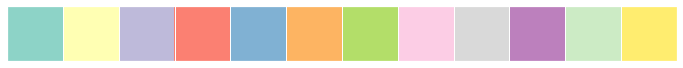

In [13]:
# Configuring IPython 
%load_ext autoreload
%autoreload 2

# Configuring matplotlib
%matplotlib inline

# Configuring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuring color palette
sns.set()
colors = sns.color_palette("Set3")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})

# Save plots to files
SAVE = True

# Verbosity
VERBOSE = False

## Loading family cross-validation results

In [9]:
# WARNINGS:
# - Make sure the families IDs are correct
# - Make sure the test data sufixes are correct

# Families IDs
family_ids = [0, 1, 3, 7, 10, 14, 30, 32, 33, 43]

# Prepare test data filepaths
tests = [
    f"famid_{famid}_positivo_1000_random_0.csv"
    for famid in family_ids
    
]

# Initiliaze data
data = {}

# Prepare data
for famid, test in zip(family_ids, tests):
    # Load ensemble
    ensemble = Ensemble(f"../results/models/families/famid{famid}/model-famid-{famid}-21-adamw-lc7-2021-10-05")
    
    # Create DiabNetReport
    tmp = DiabNetReport(ensemble, test, use_negatives=False)
    
    # Get number of positive and negative family members
    t = pd.read_csv(f"../data/datasets/visits_sp_unique_test_{test}").T2D.value_counts()
    
    # Calculate metrics
    data[f"famid{famid}"] = {
        "auc": tmp.auc(bootnum=1000, interval='HDI'),
        "f1": tmp.f1(bootnum=1000, interval='HDI'),
        "acc": tmp.acc(bootnum=1000, interval='HDI'),
        "bacc": tmp.bacc(bootnum=1000, interval='HDI'),
        "precision": tmp.precision(bootnum=1000, interval='HDI'),
        "sensitivity": tmp.sensitivity(bootnum=1000, interval='HDI'),
        "specificity": tmp.specificity(bootnum=1000, interval='HDI'),
        "avgprec": tmp.average_precision(bootnum=1000, interval='HDI'),
        "ece": tmp.ece(bootnum=10000, interval='HDI'),
        "mce": tmp.mce(bootnum=10000, interval='HDI'),
        "n": {'value': t[0] + t[1]},
        "pos%": {'value': t[1]/(t[0]+ t[1])},
    }

# Convert to pandas.DataFrame
tmp = data
raw_data = pd.DataFrame.from_dict(data, orient='index')
data = raw_data.applymap(lambda x: x['value'])
    
if VERBOSE:
    display(data)
    
if SAVE:
    if not os.path.exists("./results"):
        os.makedirs("./results")
    data.to_csv("./results/family_metrics.csv")

In [11]:
display(data)

,auc,f1,acc,bacc,precision,sensitivity,specificity,avgprec,ece,mce,n,pos%
famid0,0.967320,0.800000,0.915493,0.843682,0.923077,0.705882,0.981481,0.928865,0.075730,0.734772,71,0.239437
famid1,0.987737,0.933333,0.951613,0.943701,0.954545,0.913043,0.974359,0.983539,0.049540,0.680465,124,0.370968
famid3,0.952241,0.772727,0.953704,0.859203,0.809524,0.739130,0.979275,0.857263,0.035365,0.668305,216,0.106481
famid7,0.962366,0.852941,0.902913,0.912186,0.783784,0.935484,0.888889,0.948819,0.073163,0.667404,103,0.300971
famid10,0.933993,0.720000,0.888000,0.835396,0.692308,0.750000,0.920792,0.809971,0.087355,0.669844,125,0.192000
famid14,0.928472,0.739130,0.869565,0.862500,0.653846,0.850000,0.875000,0.861843,0.123311,0.684077,92,0.217391
famid30,0.981944,0.829268,0.923913,0.897222,0.809524,0.850000,0.944444,0.937462,0.062198,0.756056,92,0.217391
famid32,0.981481,0.888889,0.939394,0.923611,0.888889,0.888889,0.958333,0.957912,0.066478,0.876078,66,0.272727
famid33,0.973214,0.727273,0.903226,0.785714,1.000000,0.571429,1.000000,0.927556,0.100387,0.523020,62,0.225806
famid43,0.941667,0.862745,0.905405,0.908333,0.814815,0.916667,0.900000,0.901427,0.088426,0.367441,74,0.324324


## Plot 1: Barplot of family cross-validation metrics

[description]: What we find out with this plot?

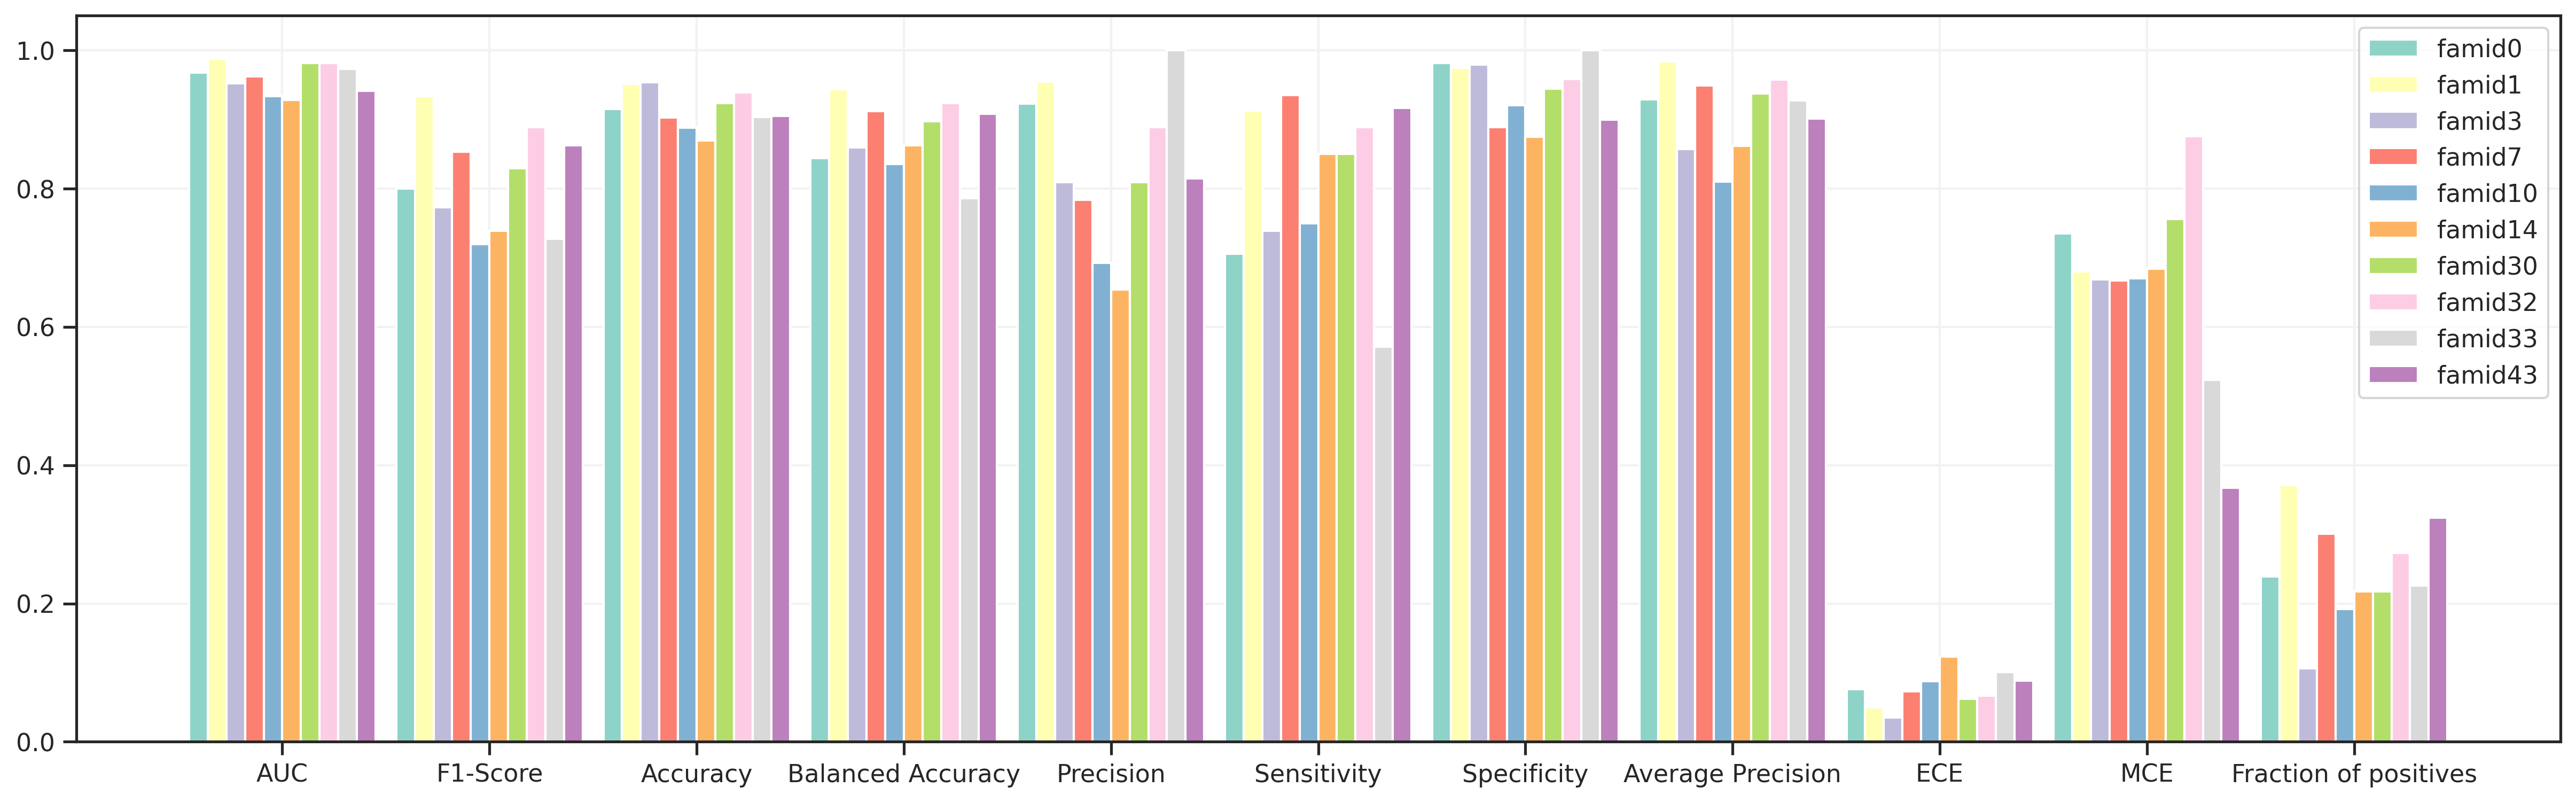

In [14]:
# Create figure
plt.figure(figsize=(20, 6), dpi=300)

# Create subplot
ax = plt.subplot(111)

# Barplot metrics
barplot(
    ax,
    data,
    selection=[
        "auc",
        "f1",
        "acc",
        "bacc",
        "precision",
        "sensitivity",
        "specificity",
        "avgprec",
        "ece",
        "mce",
        "pos%",
    ],
    labels=[
        "AUC",
        "F1-Score",
        "Accuracy",
        "Balanced Accuracy",
        "Precision",
        "Sensitivity",
        "Specificity",
        "Average Precision",
        "ECE",
        "MCE",
        "Fraction of positives",
    ],
    rotation=0,
    ha="center",
    colors=colors,
    total_width=0.9,
    single_width=1,
)

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot1.svg", dpi=300)

## Inspect Families Datasets

[description]

### Preparing tests datasets

In [16]:
# Prepare test data filepaths
tests = {
    famid:pd.read_csv(f"../data/datasets/visits_sp_unique_test_famid_{famid}_positivo_1000_random_0.csv")
    for famid in family_ids
    }

if VERBOSE:
    display(tests)

### Inspect age

In [17]:
# Get ages of each family
ages = pd.DataFrame({famid:tests[famid].AGE for famid in family_ids})

#### Plot 2: Boxplot of ages of each family dataset

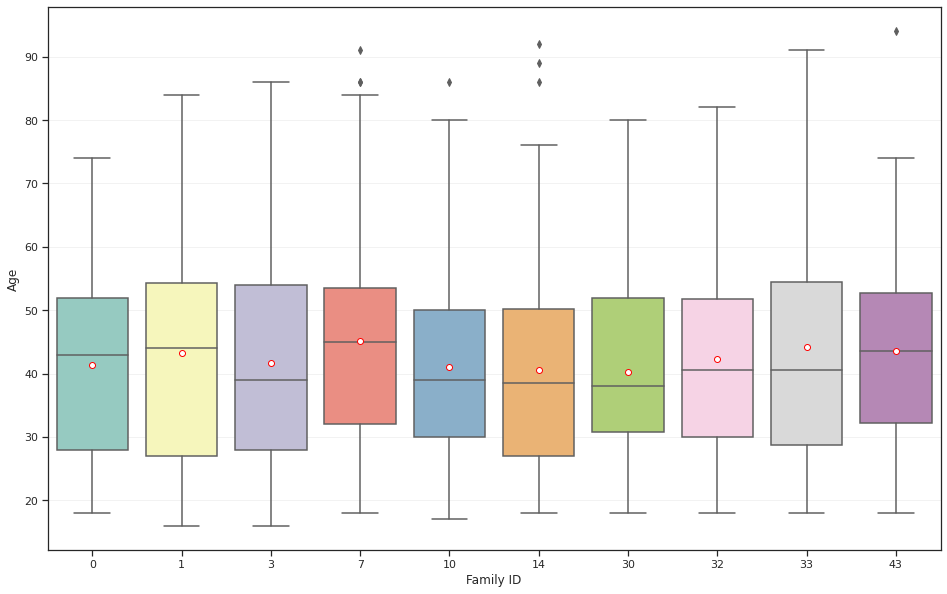

<Figure size 432x288 with 0 Axes>

In [18]:
# Create figure
fig, ax = plt.subplots(1, figsize=(16, 10))

# Plot boxplot for each family
sns.boxplot(
    data=ages, 
    palette=colors, 
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"red"}
)

# Configuring plot
ax.set_xlabel('Family ID')
ax.set_ylabel('Age')

# Display plot
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot2.svg", dpi=300)

#### Plot 3: Violinplot of ages of each family dataset

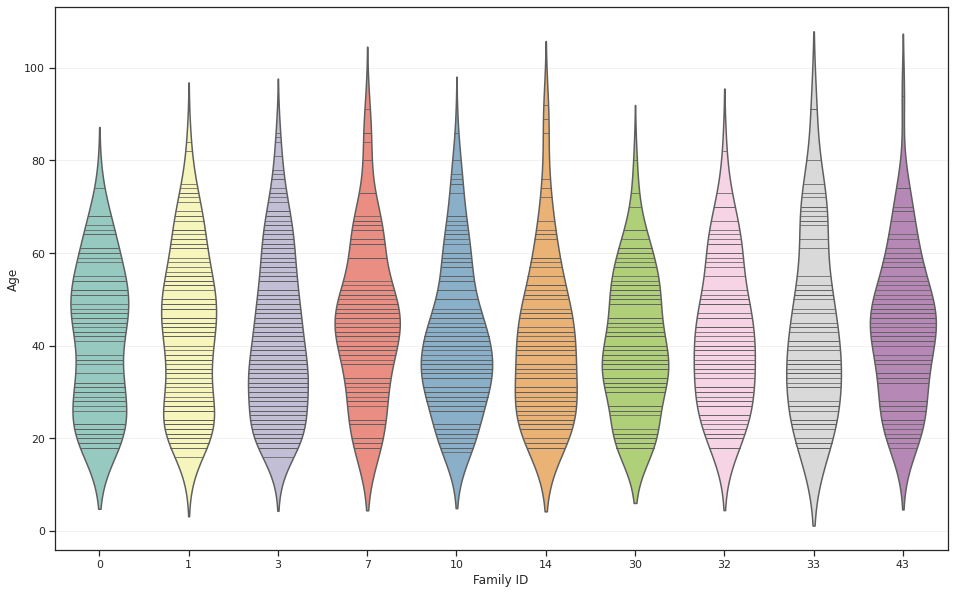

<Figure size 432x288 with 0 Axes>

In [19]:
# Create figure
fig, ax = plt.subplots(1, figsize=(16, 10))

# Violin plot age
sns.violinplot(data=ages, inner="stick", palette=colors, grid=True)

# Configuring plot
ax.set_xlabel('Family ID')
ax.set_ylabel('Age')

# Display plot
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot3.svg", dpi=300)    

### Inspect predictions

[description]

In [26]:
# Prepare samples and predictions dictionaries
# - `samples` accumulates raw features of each individual in a list by family id
# - predictions accumulates ensemble predictions and mean prediction of each individual by family id
samples, predictions = {}, {}

for famid in family_ids:
    # Test data
    fn = f"../data/datasets/visits_sp_unique_test_famid_{famid}_positivo_1000_random_0.csv"
    
    # Load ensemble
    ensemble = Ensemble(f"../results/models/families/famid{famid}/model-famid-{famid}-21-adamw-lc7-2021-10-05")

    # Get feature names
    feature_names = get_feature_names(
        fn, 
        use_sex=True,
        use_parents_diagnosis=True
    )
    
    # Predictor
    predictor = Predictor(
        ensemble, 
        feature_names, 
        negatives_csv=None
    )
    
    # Get encoded features
    samples[famid] = pd.read_csv(fn)[feature_names].values
    
    # Predictions
    predictions[famid] = {}
    predictions[famid]['values'] = [
        predictor.patient(f, age=-1, samples_per_model=1)
        for f in samples[famid]
    ]
    predictions[famid]['mean'] = np.array(
                [
                    np.mean(preds) for preds in predictions[famid]['values']
                ]
    )
    predictions[famid]['target'] = pd.read_csv(fn)['T2D'].values
    
if VERBOSE:
    display(predictions)
    display(samples)

In [27]:
# Prepare data in pandas DataFrame for seaborn plots
data = pd.DataFrame()

# Preparing data
for famid in family_ids:
    # Extract data
    age = samples[famid][:,-4].astype('float64')
    targets = predictions[famid]['target']
    preds = predictions[famid]['mean'].astype('float64')
    labels = (predictions[famid]['mean'] >= 0.5).astype(int) == predictions[famid]['target']
    family = len(age) * [str(famid)]
    
    # Calculate TP, TN, FP, FN
    confusion = [None] * len(age)
    for i in range(len(predictions[famid]['mean'])):
        p = (predictions[famid]['mean'][i] >= 0.5).astype(int)
        if p == predictions[famid]['target'][i]:
            if p == 1:
                confusion[i] = 'TP'
            else:
                confusion[i] = 'TN'
        else:
            if p == 1:
                confusion[i] = 'FP'
            else:
                confusion[i] = 'FN'
    
    # Save to a pandas DataFrame
    tmp = pd.DataFrame(
        {
            'age': age,
            'targets': targets,
            'predictions': preds,
            'labels': labels,
            'ID': family,
            'confusion': confusion
        }
    )
    
    # Append
    data = data.append(tmp)

if VERBOSE:
    display(data)
    
if SAVE:
    if not os.path.exists("./results"):
        os.makedirs("./results")
    data.to_csv("./results/family_data.csv")

#### Plot 4: Violin plot of ages splitted by correct/incorrect predictions

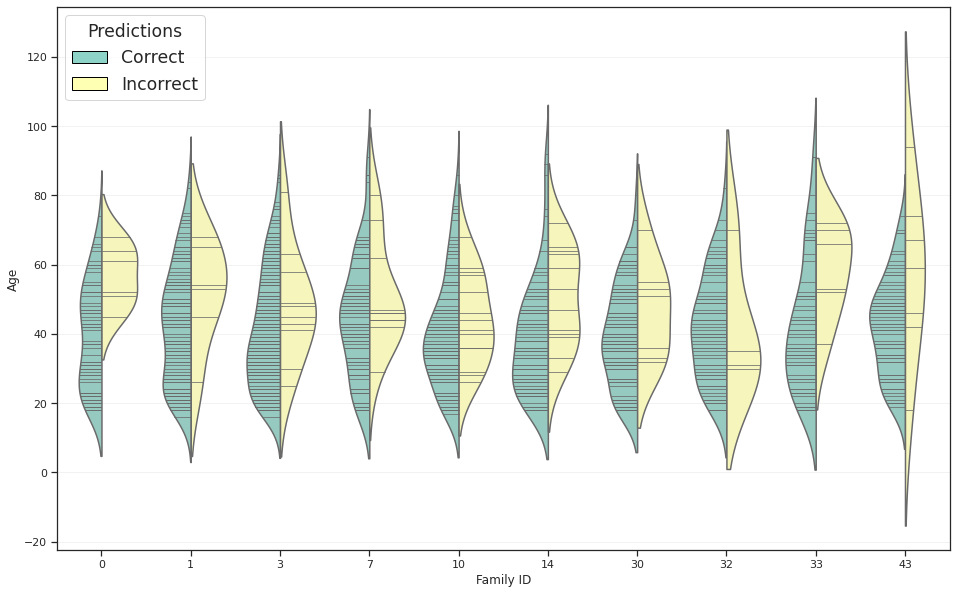

<Figure size 432x288 with 0 Axes>

In [28]:
# Create figure
fig, ax = plt.subplots(1, figsize=(16, 10))

# Violin plot age
ax = sns.violinplot(
    data=data,
    x='ID',
    y='age',
    hue='labels',
    hue_order=[True, False],
    split=True,
    inner='stick',
    palette=colors
)

# Configuring plot
ax.set_xlabel('Family ID')
ax.set_ylabel('Age')

# Configuring legend
ax.legend(
    handles=[
        Patch(facecolor=colors[0], edgecolor='black', label='Correct'),
        Patch(facecolor=colors[1], edgecolor='black', label='Incorrect'),
    ],
    fontsize='x-large',
    title_fontsize='x-large',
    title='Predictions',
    loc='upper left'
)

# Display plot
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot4.svg", dpi=300)  

#### Plot 5: Violin plot of ages splitted by TP/TN/FP/FN

[description]

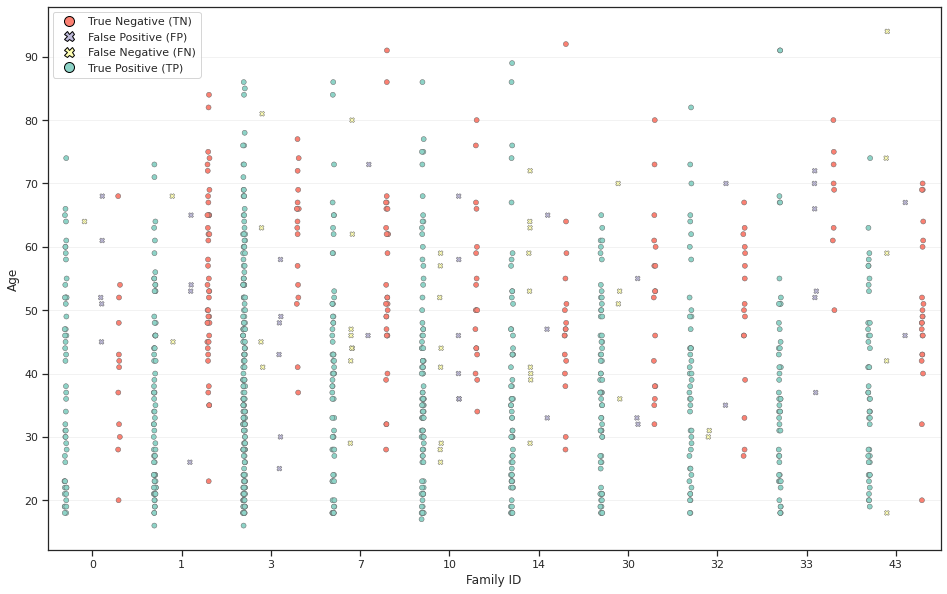

<Figure size 432x288 with 0 Axes>

In [30]:
# Create figure
fig, ax = plt.subplots(1, figsize=(16, 10))

# Violin plot age
sns.stripplot(
    data=data[data.labels], 
    x='ID', 
    y='age', 
    hue='confusion',
    hue_order=['TN', 'FP', 'FN', 'TP'],
    marker='o',
    dodge=True,
    palette=colors,
    jitter=0.05, 
    linewidth=0.5,
    ax=ax
)

# Violin plot age
sns.stripplot(
    data=data[~data.labels], 
    x='ID', 
    y='age', 
    hue='confusion',
    hue_order=['TN', 'FP', 'FN', 'TP'],
    marker='X',
    dodge=True,
    palette=colors,
    jitter=0.05, 
    linewidth=0.5,
    ax=ax
)

# Configuring plot
ax.set_xlabel('Family ID')
ax.set_ylabel('Age')

# Configuring legend
ax.legend(
    handles=[
        Line2D([0], [0], marker='o', color='w', label='True Negative (TN)', markerfacecolor=colors[3], markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='X', color='w', label='False Positive (FP)', markerfacecolor=colors[2], markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='X', color='w', label='False Negative (FN)', markerfacecolor=colors[1], markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='True Positive (TP)', markerfacecolor=colors[0], markersize=10, markeredgecolor='black'),
    ],
    loc='upper left'
)

# Display plot
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot5.svg", dpi=300)

#### Plot 6: Violin plot of prediction probability by correct/incorrect predictions

[description]

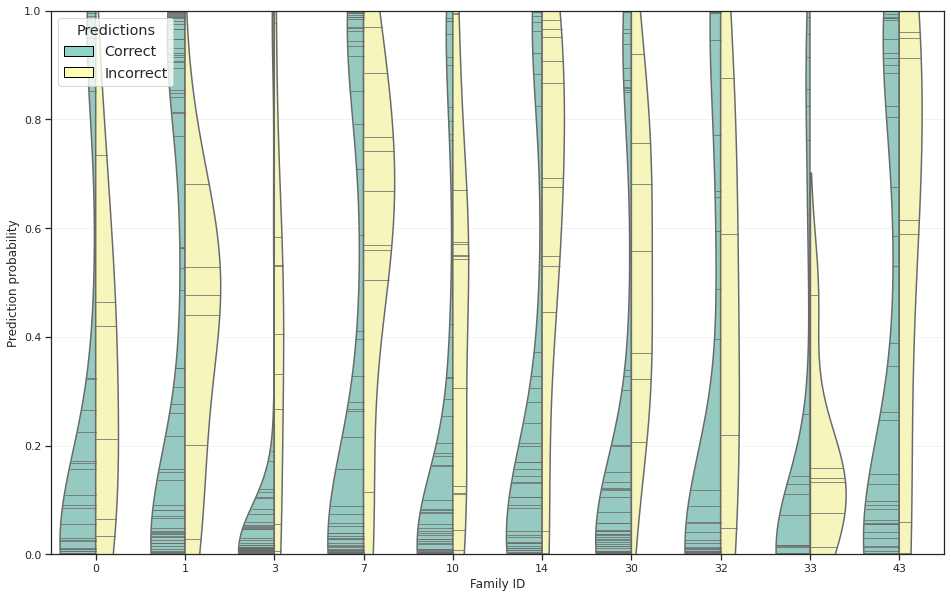

<Figure size 432x288 with 0 Axes>

In [31]:
# Create figure
fig, ax = plt.subplots(1, figsize=(16, 10))

# Violin plot age
ax = sns.violinplot(
    data=data, 
    x='ID', 
    y='predictions', 
    hue='labels',
    hue_order=[True, False],
    split=True, 
    inner='stick',
    palette=colors
)

# Configuring plot
ax.set_ylim(0, 1)
ax.set_xlabel('Family ID')
ax.set_ylabel('Prediction probability')

# Configuring legend
ax.legend(
    handles=[
        Patch(facecolor=colors[0], edgecolor='black', label='Correct'),
        Patch(facecolor=colors[1], edgecolor='black', label='Incorrect'),
    ],
    fontsize='large',
    title_fontsize='large',
    title='Predictions',
    loc='upper left'
)

# Display plot
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot6.svg", dpi=300)  

### Hierarchical clustering of features

In [32]:
# Prepare data in pandas DataFrame for seaborn plots
data = pd.DataFrame()

# Preparing data
for famid in samples.keys():
    tmp = pd.DataFrame(samples[famid])
    data = data.append(tmp)

# Transform sex to int
data[1001][data[1001] == 'F'] = 0
data[1001][data[1001] == 'M'] = 2

# Rename columns
data.columns = feature_names

# Rename index
index = pd.DataFrame()
for famid in tests.keys():
    tmp = pd.DataFrame(tests[famid].famid)
    index = index.append(tmp)
data.index = list(index.famid)

if VERBOSE:
    display(data)

#### Family ID

[description]

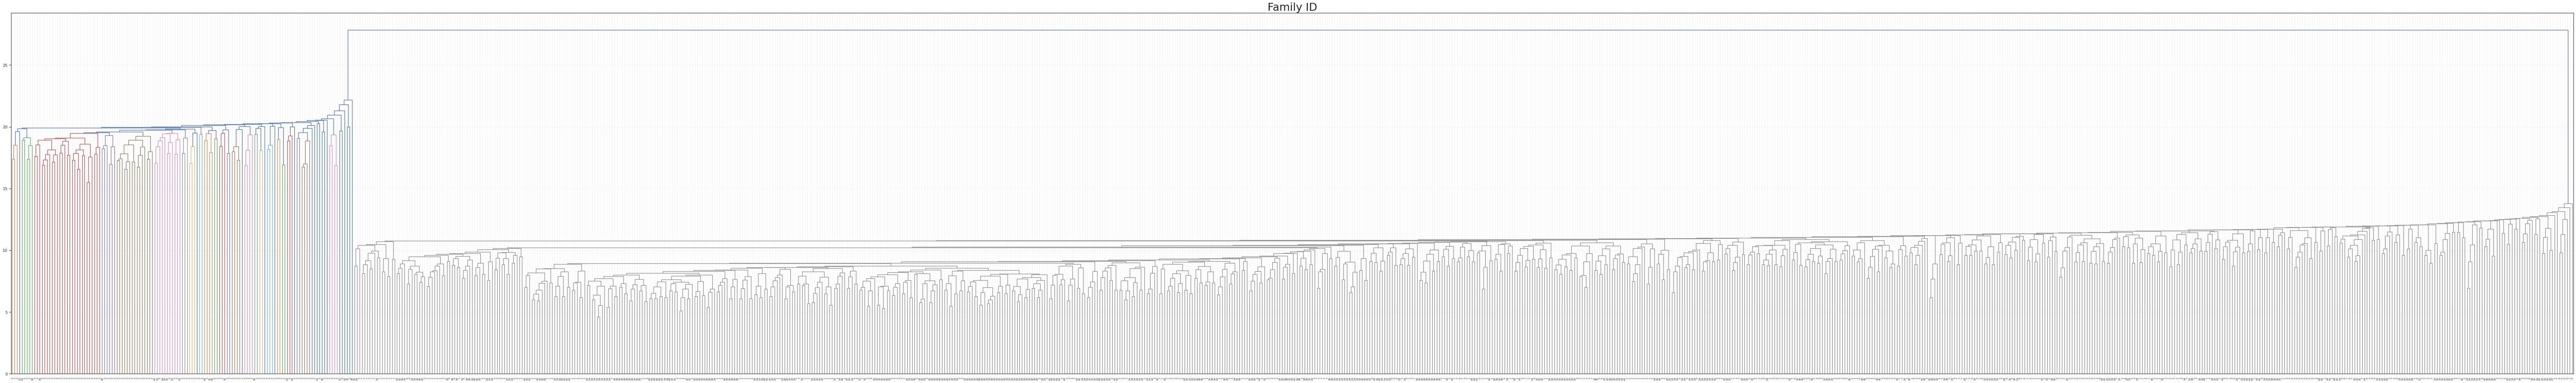

<Figure size 432x288 with 0 Axes>

In [33]:
# Hierarchical clustering of features

# Create figure
fig, ax = plt.subplots(1, figsize=(100, 15))

# Calculate distances
linked = linkage(
    data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]], # Ignore non-snp data
    method='average', # complete or average
    metric='euclidean' # correlation or euclidean
)

# Create dendogram
scipy.cluster.hierarchy.dendrogram(
    linked, 
    labels=data.index, 
    distance_sort='descending', 
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=7.,
    ax=ax
)

# Title
plt.title("Family ID", fontsize=30)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot7-1.svg", dpi=300)

#### Predicted label

[description]

In [34]:
# Rename index
index = []
for famid in predictions.keys():
    index += predictions[famid]['mean'].tolist()
data.index = (np.asarray(index) >= 0.5).astype(int)

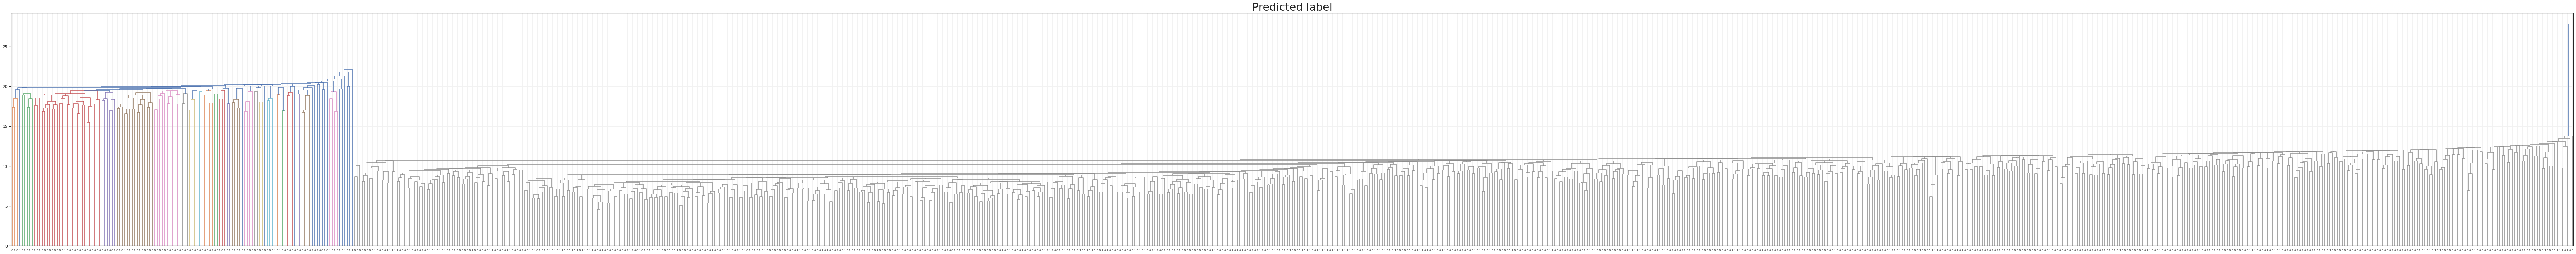

<Figure size 432x288 with 0 Axes>

In [35]:
# Hierarchical clustering of features

# Create figure
fig, ax = plt.subplots(1, figsize=(100, 10))

# Calculate distances
linked = linkage(
    data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]], # Ignore non-snp data
    method='average', # complete or average
    metric='euclidean' # correlation or euclidean
)

# Create dendogram
scipy.cluster.hierarchy.dendrogram(
    linked, 
    labels=data.index, 
    distance_sort='descending', 
    show_leaf_counts=True,
    leaf_rotation=0,
    leaf_font_size=7.,
    ax=ax
)

# Title
plt.title("Predicted label", fontsize=30)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot7-2.svg", dpi=300)

#### Actual label

[description]

In [36]:
# Rename index
index = []
for famid in predictions.keys():
    index += predictions[famid]['target'].tolist()
data.index = index

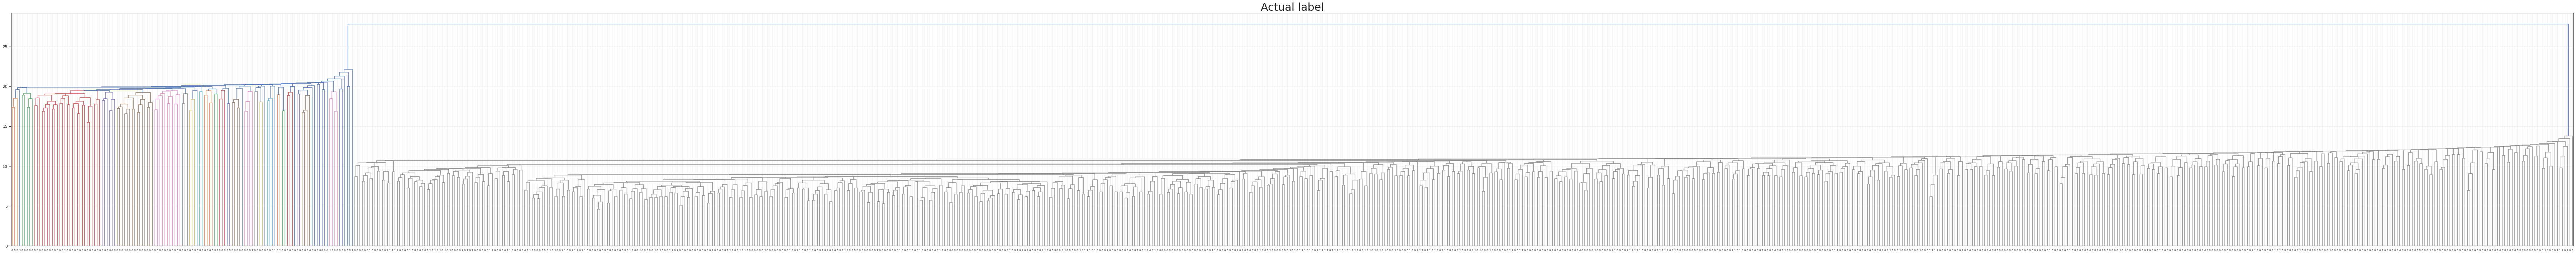

<Figure size 432x288 with 0 Axes>

In [37]:
# Hierarchical clustering of features

# Create figure
fig, ax = plt.subplots(1, figsize=(100, 10))

# Calculate distances
linked = linkage(
    data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]], # Ignore non-snp data
    method='average', # complete or average
    metric='euclidean' # correlation or euclidean
)

# Create dendogram
scipy.cluster.hierarchy.dendrogram(
    linked, 
    labels=data.index, 
    distance_sort='descending', 
    show_leaf_counts=True,
    leaf_rotation=0,
    leaf_font_size=7.,
    ax=ax
)

# Title
plt.title("Actual label", fontsize=30)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot7-3.svg", dpi=300)

### Heatmap of features

[description]

/home/ABTLUS/jose.pereira/projects/diabnet/.venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


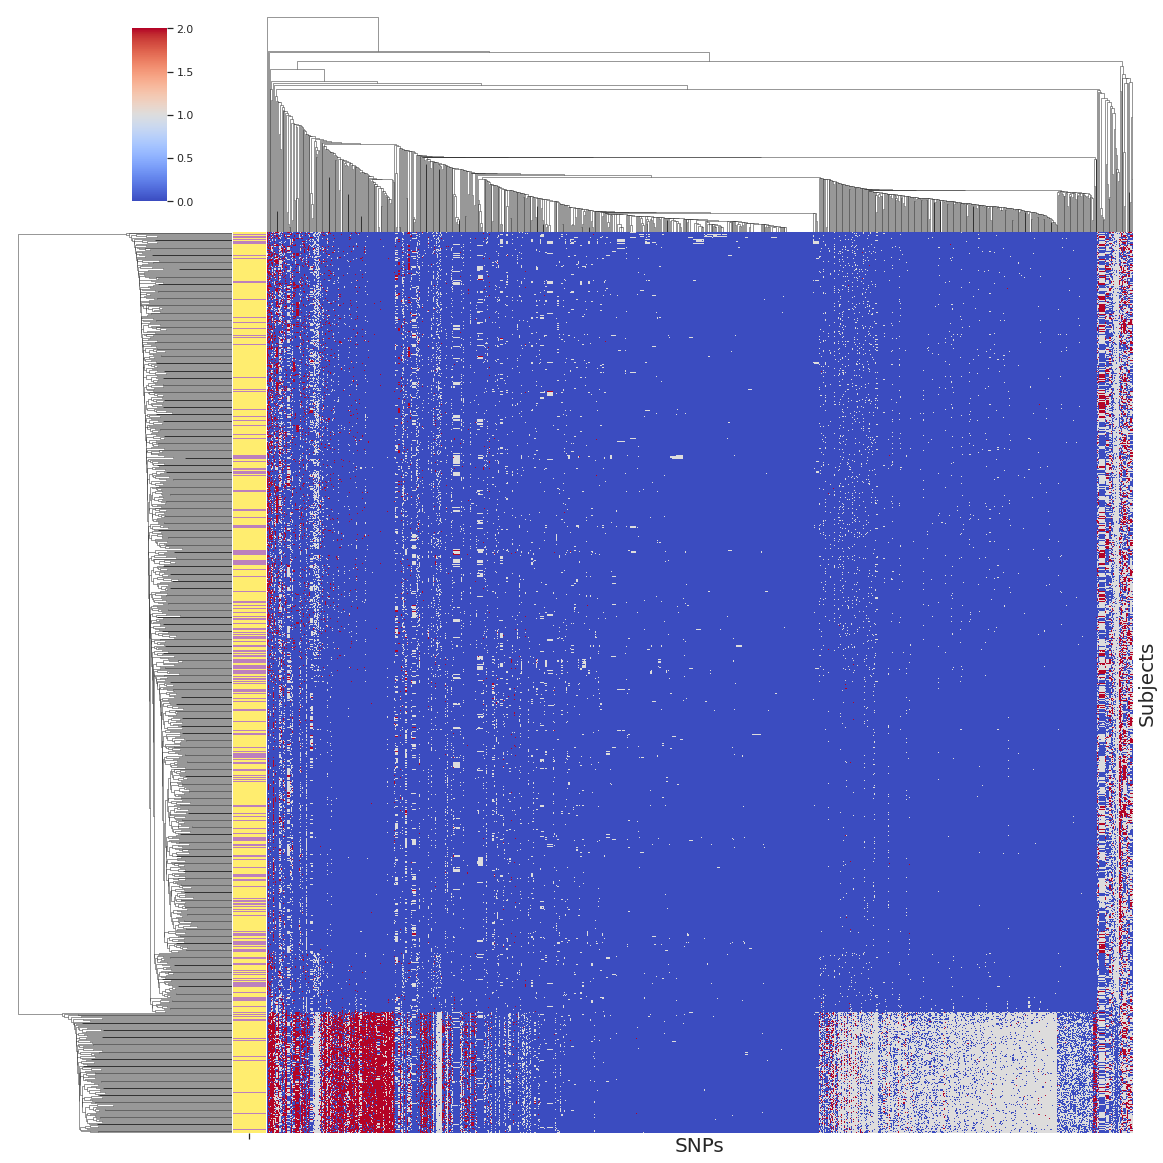

<Figure size 432x288 with 0 Axes>

In [38]:
# Row colors
row_colors = pd.Series(index, index=data.index).map(dict(zip(index, colors)))

# Plot heatmap
g = sns.clustermap(
    data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]].astype(float), # Ignore non-snp data
    cmap='coolwarm',
    metric="euclidean", 
    method="average",
    figsize=(16,16),
    cbar_pos=(0.12, 0.82, .03, .15),
    row_colors=row_colors,
    yticklabels=False,
    xticklabels=False
)

# option 1
ax = g.ax_heatmap
ax.set_xlabel("SNPs", fontsize=20)
ax.set_ylabel("Subjects", fontsize=20)

# Display plot
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook4-plot8.svg", dpi=300)